# Phishing Email Detection using NLP & Logistic Regression
A project that applies machine learning to detect phishing emails using text mining and Logistic Regression.

## Step 1: Import Libraries

In [1]:
# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np

## Step 2: Load and Clean Raw Data
Drop irrelevant columns, rename for clarity, and remove missing entries.

In [2]:
# Data Cleaning and preprocessing
# Load dataset
df_phishing = pd.read_csv('Phishing_Email.csv')  

In [3]:
# Drop any columns that start with 'Unnamed' and any empty 'Label' column
df_phishing = df_phishing.drop(columns=[col for col in df_phishing.columns if col.startswith('Unnamed') or col.strip().lower() == 'label'])

In [4]:
# Rename columns for consistency
df_phishing.rename(columns={'Email Text': 'EmailText', 'Email Type': 'Label'}, inplace=True)

In [5]:
# Drop rows with missing values
df_phishing.dropna(inplace=True)

## Step 3: Clean Email Text
Remove special characters using regular expressions.

In [6]:
# Clean email text: remove special characters, keep letters, numbers, and spaces
df_phishing['EmailText'] = df_phishing['EmailText'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)

## Step 4: Preview and Export Cleaned Data
View shape and save the cleaned dataset for reuse.

In [7]:
# Preview cleaned data
print("Shape after cleaning:", df_phishing.shape)
print(df_phishing.head())

Shape after cleaning: (18634, 2)
                                           EmailText           Label
0  re  6  1100  disc  uniformitarianism  re  1086...      Safe Email
1  the other side of  galicismos   galicismo  is ...      Safe Email
2  re  equistar deal tickets are you still availa...      Safe Email
3  \nHello I am your hot lil horny toy\n    I am ...  Phishing Email
4  software at incredibly low prices  86  lower  ...  Phishing Email


In [8]:
# Export cleaned data
df_phishing.to_csv("phishing_cleaned.csv", index=False)

## Step 5: Load Cleaned Dataset
Reload the cleaned dataset into memory.

In [9]:
# Load data
df = pd.read_csv('phishing_cleaned.csv')  

In [10]:
# Preview
print(df.head())

                                           EmailText           Label
0  re  6  1100  disc  uniformitarianism  re  1086...      Safe Email
1  the other side of  galicismos   galicismo  is ...      Safe Email
2  re  equistar deal tickets are you still availa...      Safe Email
3  \nHello I am your hot lil horny toy\n    I am ...  Phishing Email
4  software at incredibly low prices  86  lower  ...  Phishing Email


## Step 6: Prepare Features and Labels
Map textual labels to binary values and define input/output variables.

In [11]:
#  Columns are 'EmailText' and 'Label' (1 = phishing, 0 = not)
df['Label'] = df['Label'].map({'Phishing Email': 1, 'Safe Email': 0})
X = df['EmailText']
y = df['Label']

## Step 7: Split Data for Training
Separate dataset into training and testing sets.

In [12]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Step 8: TF-IDF Vectorization
Convert email content into numerical features using TF-IDF.

In [13]:
# TF-IDF vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.9)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

## Step 9: Train Logistic Regression Model
Fit a classifier to the training data.

In [14]:
# Train classifier
model = LogisticRegression()
model.fit(X_train_vec, y_train)

LogisticRegression()

## Step 10: Evaluate Model (Default Threshold)
Print confusion matrix and classification report.

In [15]:
# Predict and evaluate
y_pred = model.predict(X_test_vec)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[2171   38]
 [ 113 1405]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      2209
           1       0.97      0.93      0.95      1518

    accuracy                           0.96      3727
   macro avg       0.96      0.95      0.96      3727
weighted avg       0.96      0.96      0.96      3727



## Step 11: Threshold Tuning to Improve Recall
Lower the decision threshold to increase phishing recall.

In [16]:
# Predict probabilities instead of labels
y_probs = model.predict_proba(X_test_vec)[:, 1]

# Set a new threshold (e.g., 0.3 to catch more phishing emails)
threshold = 0.3
y_pred_threshold = (y_probs >= threshold).astype(int)

# Re-evaluate with adjusted threshold
print(f"\n Classification Report with Threshold = {threshold} ")
print(classification_report(y_test, y_pred_threshold))
print(confusion_matrix(y_test, y_pred_threshold))



--- Classification Report with Threshold = 0.3 ---
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      2209
           1       0.88      1.00      0.94      1518

    accuracy                           0.94      3727
   macro avg       0.94      0.95      0.94      3727
weighted avg       0.95      0.94      0.95      3727

[[2010  199]
 [   6 1512]]


## Step 12: TF-IDF Bar Chart
Display top words and their importance using a horizontal bar chart.

In [17]:
# Filter only phishing emails in the training set
X_train_phishing = X_train[y_train == 1]

In [18]:
# Re-fit TF-IDF only on phishing emails
phishing_vec = vectorizer.fit_transform(X_train_phishing)
feature_names = vectorizer.get_feature_names_out()
mean_scores = np.asarray(phishing_vec.mean(axis=0)).flatten()

In [19]:
# Create a pandas Series for easier handling
tfidf_scores = pd.Series(mean_scores, index=feature_names)
top_tfidf = tfidf_scores.sort_values(ascending=False).head(20)

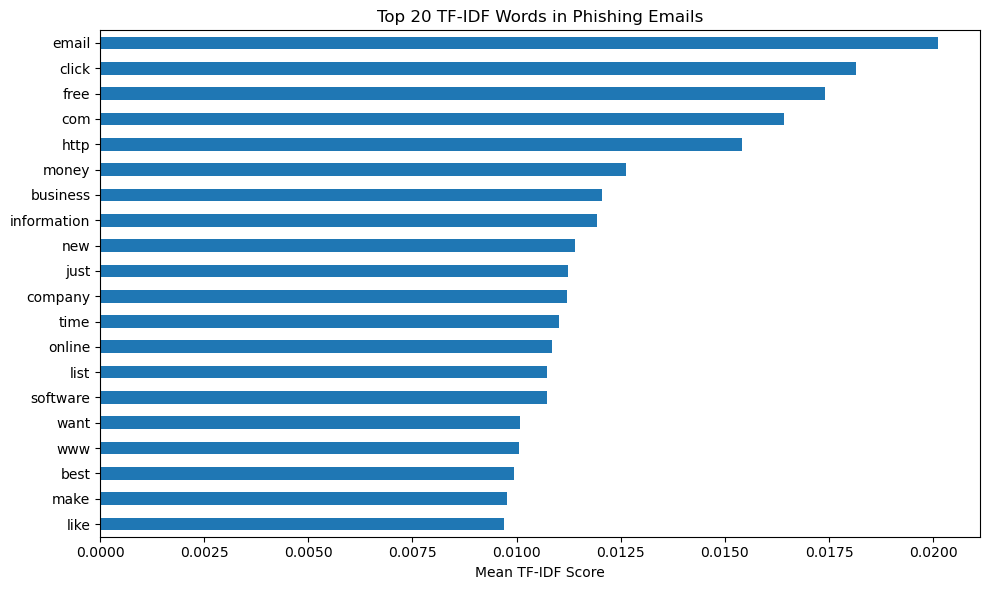

In [20]:
# Bar Chat
plt.figure(figsize=(10,6))
top_tfidf.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Top 20 TF-IDF Words in Phishing Emails')
plt.xlabel('Mean TF-IDF Score')
plt.tight_layout()
plt.show()

##  Step 13: Word Cloud Visualization
Show high-frequency phishing indicators.

In [21]:
# Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white')
wordcloud.generate_from_frequencies(top_tfidf.to_dict())

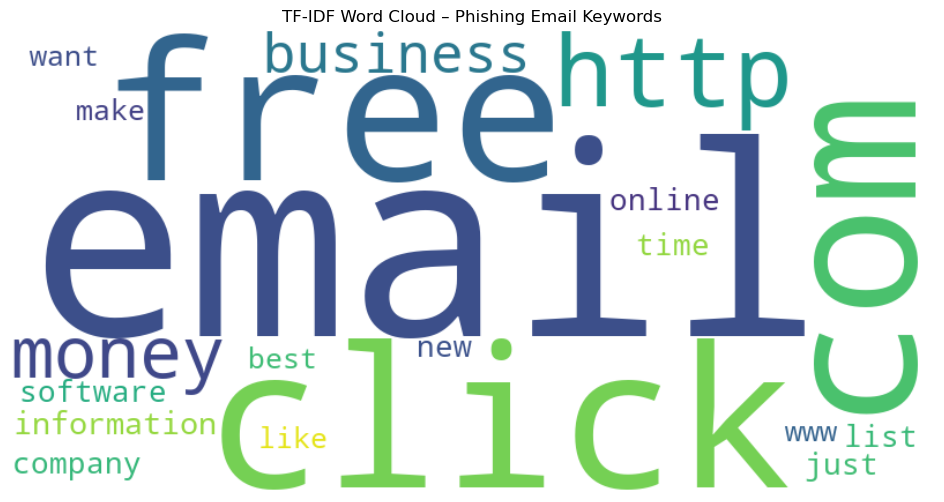

In [23]:
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('TF-IDF Word Cloud – Phishing Email Keywords')
plt.show()